In [38]:
import os
import numpy as np
import librosa
import random

DATASET_PATH = "/home/gmallet/datasets/gtzan"
ROI_PATH = DATASET_PATH + "/genres_original/"

TIME_SERIES_LENGTH = 128
HOP_LENGTH = 512
CATEGORIES = os.listdir(ROI_PATH)

sr = 22050
SONG_DURATION = 29
TOTAL_SAMPLES = SONG_DURATION * sr
NB_SLICES = 10
SAMPLES_PER_SLICE = int(TOTAL_SAMPLES / NB_SLICES)

def get_files(root_path, extension):
    files_paths = []
    for root, _, files in os.walk(root_path, topdown=True):
        files_paths += [os.path.join(root, file) for file in files if file.endswith(extension)]
    return files_paths

def extract_audio_features(files_paths):
    labels = []
    features = []
    for i, file_path in enumerate(files_paths):
        song, sr = librosa.load(file_path, duration=SONG_DURATION)
        genre = file_path.split("/")[-2]
        index = CATEGORIES.index(genre)
        for s in range(NB_SLICES):
            start_sample = SAMPLES_PER_SLICE * s
            end_sample = start_sample + SAMPLES_PER_SLICE
            mfcc = librosa.feature.mfcc(y=song[start_sample:end_sample], sr=sr, n_mfcc=13)
            mfcc = mfcc.T
            labels.append(index)
            features.append(mfcc.tolist())
        print(
            "\rExtracted features audio track %i of %i."
            % (i+1, len(files_paths)), end=''
        )
    print()
    return (np.array(features), np.array(labels))


# USE ONLY ONE SAMPLE PER SONG, AND STILL MFCC ON THE WHOLE SONG SO REALLY BAD
def bad_extract_audio_features(files_paths):
    nb_files = len(files_paths)
    
    features = np.zeros(
        (nb_files, TIME_SERIES_LENGTH, 13), dtype=np.float64
    )
    
    
    labels = np.zeros(
        (nb_files, 1), dtype=np.int32
     )
    
    for i, file in enumerate(files_paths):
        y, sr = librosa.load(file)
        mfcc = librosa.feature.mfcc(
            y=y, sr=sr, hop_length=HOP_LENGTH, n_mfcc=13
        )
            
        genre = file.split("/")[-2]
        index = CATEGORIES.index(genre)
        
        labels[i][0] = index 
        features[i, :] = mfcc.T[0:TIME_SERIES_LENGTH, :]
        print(
            "\rExtracted features audio track %i of %i."
            % (i+1, nb_files), end=''
        )
    print()
    return (features, labels)



def load_data(files_path):
    files_paths = get_files(files_path, "wav")
    random.shuffle(files_paths)
    a, b = int(len(files_paths) * 0.8), int(len(files_paths) * 0.9)
    train_fp, val_fp, test_fp = files_paths[:a], files_paths[a:b], files_paths[b:]

    # SHOULD SAVE THIS TO JSON OR SMTHG
    return {
        "train": extract_audio_features(train_fp),
        "validate": extract_audio_features(val_fp),
        "test": extract_audio_features(test_fp),
    }

dataset = load_data(ROI_PATH)

Extracted features audio track 799 of 799.
Extracted features audio track 100 of 100.
Extracted features audio track 100 of 100.


In [39]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import PIL
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [40]:
print(dataset["train"][0].shape)
print(dataset["train"][1].shape)

(7990, 125, 13)
(7990,)


In [61]:
# TRAINING
# I DON'T HAVE MUCH TO SAY ON THESE 2 PARAMETERS, TRYED DIFFERENTS ONE RANDOMLY, THESE WERE WORKING WELL, 
# EVEN THOUGH BATCH_SIZE IS MAYBE A BIT TOO BIG, SO TRAINING TAKE A LOT OF TIME.
BATCH_SIZE = 30
NUM_EPOCHS = 200

def get_model(input_shape, output_size):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'), 
        tf.keras.layers.Dense(output_size, activation='softmax')
    ])
    model.compile(optimizer = "adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

def train(dataset):
    input_shape = (dataset["train"][0].shape[1], dataset["train"][0].shape[2])
    model = get_model(input_shape, 10)
    return model, model.fit(
        dataset["train"][0],
        dataset["train"][1],
        validation_data=dataset["validate"],
        batch_size=BATCH_SIZE,
        epochs=NUM_EPOCHS,
        shuffle=True
    )

In [62]:
# VISUALIZATION
import matplotlib.pyplot as plt

def show_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(NUM_EPOCHS)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [63]:
model, history = train(dataset)

Epoch 1/200
267/267 [==============================] - 2s 5ms/step - loss: 4.9459 - accuracy: 0.1479 - val_loss: 2.1391 - val_accuracy: 0.1530
Epoch 2/200
267/267 [==============================] - 1s 3ms/step - loss: 2.2228 - accuracy: 0.1743 - val_loss: 1.9016 - val_accuracy: 0.2830
Epoch 3/200
267/267 [==============================] - 1s 3ms/step - loss: 2.1252 - accuracy: 0.2188 - val_loss: 1.8266 - val_accuracy: 0.3090
Epoch 4/200
267/267 [==============================] - 1s 3ms/step - loss: 2.0769 - accuracy: 0.2359 - val_loss: 1.8052 - val_accuracy: 0.3230
Epoch 5/200
267/267 [==============================] - 1s 3ms/step - loss: 2.0212 - accuracy: 0.2513 - val_loss: 1.7966 - val_accuracy: 0.3140
Epoch 6/200
267/267 [==============================] - 1s 3ms/step - loss: 1.9831 - accuracy: 0.2632 - val_loss: 1.7930 - val_accuracy: 0.3400
Epoch 7/200
267/267 [==============================] - 1s 3ms/step - loss: 1.9537 - accuracy: 0.2747 - val_loss: 1.8159 - val_accuracy: 0.3210

Epoch 58/200
267/267 [==============================] - 1s 3ms/step - loss: 1.6341 - accuracy: 0.4019 - val_loss: 1.7333 - val_accuracy: 0.4080
Epoch 59/200
267/267 [==============================] - 1s 3ms/step - loss: 1.6037 - accuracy: 0.4247 - val_loss: 1.8284 - val_accuracy: 0.3670
Epoch 60/200
267/267 [==============================] - 1s 3ms/step - loss: 1.5947 - accuracy: 0.4232 - val_loss: 1.8160 - val_accuracy: 0.3720
Epoch 61/200
267/267 [==============================] - 1s 3ms/step - loss: 1.5665 - accuracy: 0.4310 - val_loss: 1.7111 - val_accuracy: 0.4320
Epoch 62/200
267/267 [==============================] - 1s 3ms/step - loss: 1.5874 - accuracy: 0.4257 - val_loss: 1.9025 - val_accuracy: 0.3560
Epoch 63/200
267/267 [==============================] - 1s 3ms/step - loss: 1.5884 - accuracy: 0.4224 - val_loss: 1.8172 - val_accuracy: 0.3780
Epoch 64/200
267/267 [==============================] - 1s 3ms/step - loss: 1.5562 - accuracy: 0.4359 - val_loss: 1.6925 - val_accuracy:

Epoch 115/200
267/267 [==============================] - 1s 3ms/step - loss: 1.4258 - accuracy: 0.5060 - val_loss: 1.9637 - val_accuracy: 0.4050
Epoch 116/200
267/267 [==============================] - 1s 3ms/step - loss: 1.4219 - accuracy: 0.4937 - val_loss: 1.8843 - val_accuracy: 0.4290
Epoch 117/200
267/267 [==============================] - 1s 3ms/step - loss: 1.4006 - accuracy: 0.5075 - val_loss: 1.8672 - val_accuracy: 0.4370
Epoch 118/200
267/267 [==============================] - 1s 3ms/step - loss: 1.4243 - accuracy: 0.4965 - val_loss: 1.8052 - val_accuracy: 0.4210
Epoch 119/200
267/267 [==============================] - 1s 3ms/step - loss: 1.4070 - accuracy: 0.4999 - val_loss: 1.8157 - val_accuracy: 0.4220
Epoch 120/200
267/267 [==============================] - 1s 3ms/step - loss: 1.4102 - accuracy: 0.4999 - val_loss: 2.0728 - val_accuracy: 0.3940
Epoch 121/200
267/267 [==============================] - 1s 3ms/step - loss: 1.4248 - accuracy: 0.4884 - val_loss: 1.9769 - val_ac

267/267 [==============================] - 1s 3ms/step - loss: 1.3409 - accuracy: 0.5235 - val_loss: 2.1582 - val_accuracy: 0.3940
Epoch 172/200
267/267 [==============================] - 1s 3ms/step - loss: 1.3674 - accuracy: 0.5105 - val_loss: 1.9520 - val_accuracy: 0.4480
Epoch 173/200
267/267 [==============================] - 1s 3ms/step - loss: 1.3181 - accuracy: 0.5284 - val_loss: 2.0278 - val_accuracy: 0.4350
Epoch 174/200
267/267 [==============================] - 1s 3ms/step - loss: 1.3456 - accuracy: 0.5200 - val_loss: 2.0659 - val_accuracy: 0.3930
Epoch 175/200
267/267 [==============================] - 1s 3ms/step - loss: 1.3417 - accuracy: 0.5300 - val_loss: 2.1136 - val_accuracy: 0.4590
Epoch 176/200
267/267 [==============================] - 1s 3ms/step - loss: 1.3318 - accuracy: 0.5313 - val_loss: 2.3674 - val_accuracy: 0.4220
Epoch 177/200
267/267 [==============================] - 1s 3ms/step - loss: 1.3301 - accuracy: 0.5280 - val_loss: 2.1656 - val_accuracy: 0.3580

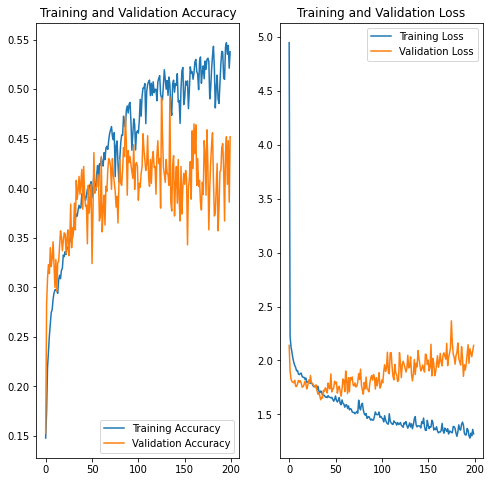

In [66]:
show_history(history)
# WITHOUT DCA, ANN IS OVERFITTING SUPER FAST + ACCURACY ISN'T ON POINT

In [67]:
# EVALUATION
model.evaluate(
    dataset["test"][0], dataset["test"][1], batch_size=20, verbose=1
)
# BAD ANN

50/50 [==============================] - 0s 3ms/step - loss: 2.1500 - accuracy: 0.3980


[2.150036096572876, 0.39800000190734863]